In [187]:
import scipy as sp
import scipy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm.notebook import tqdm
import shutil
import pathlib

from tabulate import tabulate
from scipy.interpolate import RegularGridInterpolator

from sys import getsizeof
import sys

#from IPython.display import Audio
#sound_file = 'ta_da_short.mp3'

from playsound import playsound


from platform import python_version
from importlib.metadata import version 

print(python_version())
print(version('h5py'))
print(version('tqdm'))


3.10.6
3.8.0
4.65.0


## The units

1. distances in kpc
2. masses in M_sun
3. time in 10^9 years (GYR)

1kpc/(1GyR) = 0.977 km/s ~ 1km/s



In [42]:
G = 4.5e-6

## Usefull Definitions

In [95]:
def predict_mem(NN,slices):
    return 64*(NN/1024)**3/slices


def det_slices(NN, mem=4):
    NNs = np.array(NN)
    pre = np.log((64/mem*(NNs/1024)**3))/np.log(2)
    mask = pre < 0
    pre[mask] = 0
    return np.power(2,(np.ceil(pre))).astype('i')


def det_slices_v1(NN, mem=4):
    pre = np.log((64/mem*(NN/1024)**3))/np.log(2)
    if pre < 0:
        pre = 0
    return int(np.power(2,(np.ceil(pre))))


def time_estimate(NN):
    a0 = 3.292
    b0 = -17.683
    return NN**a0*np.exp(b0)


def generate_props(NN, boundary, slices=-1, fiducial=0.7):
    
    mid = NN//2
    
    fmid = int(mid*fiducial)
    fid1 = mid-fmid
    fid2 = mid+fmid

    xs = np.linspace(-boundary,boundary,NN)
    dx   = (xs[1]-xs[0])
    rs = np.sqrt(xs**2+2.0*(xs[mid])**2)
    ks = np.fft.fftfreq(NN,d=dx)
    rho0 = 1.0/dx**3
    
    if slices == -1:
        rslices = det_slices_v1(NN,mem=4)
    else:
        rslices = slices
    
    props = {'NN':NN, 'mid':mid, 'xs':xs, 'dx':dx, 'rs':rs, 'ks':ks, 'rho0':rho0, 'slices': rslices,
             'fmid': fmid, 'fid1': fid1, 'fid2': fid2, 'fidx': xs[fid1:fid2], 'fidr': rs[fid1:fid2]}
    
    return props

def get_axis(filename, props,index=-1, axis=0):
    
    if index == -1:
        index = props['mid']
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        if axis == 0:
            myslice = np.copy(dset[index:,index,index])
            return myslice
        if axis == 1:
            myslice = np.copy(dset[index,index:,index])
            return myslice
        if axis == 2:
            myslice = np.copy(dset[index,index,index:])
            return myslice
        
def get_plane(filename,props,index,axis=0):
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        if axis == 0:
            return dset[index,:,:]
        if axis == 1:
            return dset[:,index,:]
        if axis == 2:
            return dset[:,:,index]


def get_fullarray(filename):
    with h5py.File(filename,'r') as F:
        if len(F['d1']) <= 512:
            return F['d1'][:]
        else:
            raise Exception(f"You are asking to directly handle too much data! [NN={len(F['d1'])}>512]")

def extract_fiducial(filename, fidname, props):
    fid1 = props['fid1']
    fid2 = props['fid2']
    fmid  = props['fmid']
    NN = props['NN']
    slices = props['slices']
    nn = NN//slices
    if NN < 512:
        with h5py.File(filename,'r+') as F:
            with h5py.File(fidname,'w') as Fid:
                dset = F['d1']
                Fid.create_dataset('d1',data=np.real(dset[fid1:fid2,fid1:fid2,fid1:fid2]))
    else:
        with h5py.File(filename,'r+') as F:
            dset = F['d1']
            with h5py.File(fidname,'w') as Fid:
                Fid.create_dataset('d0',(NN,2*fmid,2*fmid))
                temp = Fid['d0']
                for ii in tqdm(range(slices)):
                    temp[ii*nn:(ii+1)*nn] = np.real(dset[ii*nn:(ii+1)*nn,fid1:fid2,fid1:fid2])
                    
                Fid.create_dataset('d1',data=np.real(temp[fid1:fid2]))
                del Fid['d0']   

In [307]:
def chunked_prepare_delta(filename, props, slices=-1, debug=False, fullsum=1.0):
    
    NN = props['NN']
    mid = props['mid']
    rho0 = props['rho0']
    
    with h5py.File(filename,'w') as F:
        dset = F.create_dataset('d1',(NN,NN,NN), dtype='complex', chunks=True, maxshape=(NN,NN,NN))
        mid = NN//2
        ## This corresponds to an approximate delta function with mass 1 M_odot

        dset[mid,mid,mid]       = fullsum*rho0/8.0
        dset[mid-1,mid,mid]     = fullsum*rho0/8.0
        dset[mid,mid-1,mid]     = fullsum*rho0/8.0
        dset[mid,mid,mid-1]     = fullsum*rho0/8.0
        dset[mid-1,mid-1,mid]   = fullsum*rho0/8.0
        dset[mid,mid-1,mid-1]   = fullsum*rho0/8.0
        dset[mid-1,mid,mid-1]   = fullsum*rho0/8.0
        dset[mid-1,mid-1,mid-1] = fullsum*rho0/8.0
        
def chunked_prepare_iso(filename, props, slices=-1, debug=False):
    
    NN = props['NN']
    mid = props['mid']
    rho0 = props['rho0']
    xs = props['xs']
    
    if slices == -1:
        slices = props['slices']
    
    nn = NN//slices
    show_progress = not debug
    
    if debug:
        print("Creating an isothermal profile...\n",flush=True)
    
    with h5py.File(filename,'w') as F:
        dset = F.create_dataset('d1',(NN,NN,NN), dtype='complex', chunks=True, maxshape=(NN,NN,NN))
        
        for ii in tqdm(range(slices), disable=show_progress):
            xsub = xs[ii*nn:(ii+1)*nn]
            xx,yy,zz = np.meshgrid(xsub,xs,xs,indexing='ij')
            
            dset[ii*nn:(ii+1)*nn] = 1.0/(1.0+xx**2+yy**2+zz**2)/rho0+0j
            
        
def chunked_prepare_gal(filename, props, slices=-1, debug=False, withdm=False, withb=True, isComplex=True):
    
    NN = props['NN']
    mid = props['mid']
    rho0 = props['rho0']
    xs = props['xs']
    
    ## Bulge properties
    alpha = 1.8
    q     = 0.5
    r0_bulge = 0.075
    rcut_bulge = 2.10
    rho0_bulge = 9.93e10

    ## Thin and Thick star disks
    Rd_thin  = 2.5
    Rd_thick = 3.0
    Sigma0_thin  = 8.92e8
    Sigma0_thick = 1.83e8
    zd_thin = 0.3
    zd_thick = 0.9

    ## Gas disks
    Sigma0_HI = 5.3e7
    Sigma0_H2 = 2.18e9
    Rd_HI = 7.0
    Rd_H2 = 1.5
    Rm_HI = 4
    Rm_H2 = 12
    zd_HI = 0.085
    zd_H2 = 0.045
    
    ##DM Halo (NFW)
    rho0_dm = 8.54e6
    rh = 19.6
    gamma = 1
    
    if slices == -1:
        slices = props['slices']
    
    nn = NN//slices
    show_progress = not debug
    
    with h5py.File(filename,'w') as F:
        if isComplex:
            dset = F.create_dataset('d1',(NN,NN,NN), dtype='complex', chunks=True, maxshape=(NN,NN,NN))
        else:
            dset = F.create_dataset('d1',(NN,NN,NN), dtype='float', chunks=True, maxshape=(NN,NN,NN))
        
        
        for ii in tqdm(range(slices), desc=f'Creating density profile [{filename}]',disable=show_progress):
            xsub = xs[ii*nn:(ii+1)*nn]
            xx,yy,zz = np.meshgrid(xsub,xs,xs,indexing='ij')
                        
            R      = np.sqrt(xx**2+yy**2)
            rprime = np.sqrt(R**2+(zz/q)**2)
            r      = np.sqrt(R**2+zz**2)
            
            if isComplex:
                density = 0.0+0.0j
            else:    
                density = 0.0
            
            if withb:
                density = density + rho0_bulge*np.exp(-(rprime/rcut_bulge)**2)/np.power((1.0+rprime/r0_bulge),alpha)
                density = density + Sigma0_thin /(2.0*zd_thin )*np.exp(-np.abs(zz)/zd_thin  - R/Rd_thin )
                density = density + Sigma0_thick/(2.0*zd_thick)*np.exp(-np.abs(zz)/zd_thick - R/Rd_thick)            
                density = density + Sigma0_HI/(4.0*zd_HI)*np.exp( - Rm_HI/R - R/Rd_HI )/np.cosh(zz/(2.0*zd_HI))**2
                density = density + Sigma0_H2/(4.0*zd_H2)*np.exp( - Rm_H2/R - R/Rd_H2 )/np.cosh(zz/(2.0*zd_H2))**2
            if withdm:
                density = density + rho0_dm / (np.power(r/rh,gamma)*np.power(1+r/rh,3-gamma))
            
            dset[ii*nn:(ii+1)*nn] = density

In [308]:
rho0_dm = 8.54e6
rh = 19.6
gamma = 1



rho0_dm / ((8.5/rh)*np.power(1+8.5/rh,2))/10**6

9.580639949580473

In [309]:
def chunked_get_potential(filename, props, factor, slices=-1, debug=False, workers=4):
       
    ks = props['ks']
    NN = props['NN']
    
    if slices == -1:
        slices = props['slices']
    
    nn = NN//slices
    
    ##print(f"Slicing, the memory use will be {16*NN*NN*NN//slices/1e9} GB per array")
    ## This is true for complex arrays. In reality, kx,ky,kz and ksq are smaller because they are real, not complex
    
    eps = ks[1]/factor
    
    show_progress = not debug
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        with tqdm(total=(3*slices),desc=f'Computing Potential [{filename}]',disable=show_progress) as pbar:
            for ii in range(slices):
                a = dset[:,ii*nn:(ii+1)*nn,:]
                dset[:,ii*nn:(ii+1)*nn] = fft.fft(a,axis=0,workers=workers)
                pbar.update(1)

            for ii in range(slices):
                ksub = ks[ii*nn:(ii+1)*nn]
                kx,ky,kz = np.meshgrid(ksub,ks,ks,indexing='ij')
                ksq = np.pi*(kx**2+ky**2+kz**2)
                ## The last factor of pi comes from 4*pi/(2*pi)^2
                if ksq[0,0,0] == 0:
                    ksq[0,0,0] = np.pi*eps**2
                del kx,ky,kz
                a = dset[ii*nn:(ii+1)*nn,:,:]
                a = fft.fft2(a,axes=(1,2),workers=workers)
                a = a/ksq
                dset[ii*nn:(ii+1)*nn] = fft.ifft2(a,axes=(1,2),workers=workers)
                pbar.update(1)

            for ii in range(slices):
                a = dset[:,ii*nn:(ii+1)*nn,:]
                dset[:,ii*nn:(ii+1)*nn] =  -G*fft.ifft(a,axis=0,workers=workers)
                pbar.update(1)


In [310]:
## Make a table for mem_use, time and slice calculations


NNs = np.sort(np.concatenate((64*np.power(2,np.arange(8)),3*32*np.power(2,np.arange(7)))))

slices = det_slices(NNs,mem=4)
runtimes = time_estimate(NNs)

A = np.concatenate(([['NN','slices','mem [GB]','runtime']],np.array([NNs,slices,predict_mem(NNs,slices),runtimes]).T)).T
print(tabulate(A, tablefmt='fancy_grid',floatfmt=".2f"))





╒══════════╤═══════╤═══════╤════════╤════════╤════════╤════════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╤══════════╤══════════╤═══════════╕
│ NN       │ 64.00 │ 96.00 │ 128.00 │ 192.00 │ 256.00 │ 384.00 │ 512.00 │ 768.00 │ 1024.00 │ 1536.00 │ 2048.00 │ 3072.00 │  4096.00 │  6144.00 │   8192.00 │
├──────────┼───────┼───────┼────────┼────────┼────────┼────────┼────────┼────────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┼───────────┤
│ slices   │  1.00 │  1.00 │   1.00 │   1.00 │   1.00 │   1.00 │   2.00 │   8.00 │   16.00 │   64.00 │  128.00 │  512.00 │  1024.00 │  4096.00 │   8192.00 │
├──────────┼───────┼───────┼────────┼────────┼────────┼────────┼────────┼────────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┼───────────┤
│ mem [GB] │  0.02 │  0.05 │   0.12 │   0.42 │   1.00 │   3.38 │   4.00 │   3.38 │    4.00 │    3.38 │    4.00 │    3.38 │     4.00 │     3.38 │      4.00 │
├──────────┼───────┼───────┼────────┼────────┼────────┼───

## What are the correct factors?

I'll take them from the previous file

|R  | factor |
|---|---|
| 7 | 2.91~ |
|  5| 2.95~ |

In [311]:
## turns a file from real to complex, chunks

def complex_2_real(filename, slices):
    
    temp_filename1 = filename.split('.')[0]+'_temp1.'+filename.split('.')[-1]
    
    with tqdm(total=2*slices,desc=f'Converting [{filename}] to a real array') as pbar:
    
        with h5py.File(filename, 'r+') as Fin:
            with h5py.File(temp_filename1,'w') as Fout:
                dset_in = Fin['d1']
                NN = len(dset_in)
                nn = NN//slices
                dset_out = Fout.create_dataset('d1',(0,0,0), dtype='float', chunks=True, maxshape=(NN,NN,NN))

                for ii in range(slices):
                    dset_out.resize(((ii+1)*nn,NN, NN))
                    dset_out[(ii)*nn:(ii+1)*nn] = np.real(dset_in[(slices-ii-1)*nn:(slices-ii)*nn])
                    dset_in.resize(((slices-ii-1)*nn,NN,NN))
                    pbar.update(1)

                del dset_in


        with h5py.File(filename,'w') as Fout:
            with h5py.File(temp_filename1,'r+') as Fin:
                dset_in = Fin['d1']
                dset_out = Fout.create_dataset('d1',(0,0,0), dtype='float', chunks=True, maxshape=(NN,NN,NN))

                for ii in range(slices):
                    dset_out.resize(((ii+1)*nn,NN, NN))
                    dset_out[(ii)*nn:(ii+1)*nn] = np.real(dset_in[(slices-ii-1)*nn:(slices-ii)*nn])
                    dset_in.resize(((slices-ii-1)*nn,NN,NN))
                    pbar.update(1)

                del dset_in

    path = pathlib.Path(temp_filename1)
    path.unlink()

    
def real_2_complex(filename, slices):
    
    temp_filename1 = filename.split('.')[0]+'_temp1.'+filename.split('.')[-1]
    
    with tqdm(total=2*slices,desc=f'Converting [{filename}] to a complex array') as pbar:
        with h5py.File(filename, 'r+') as Fin:
            with h5py.File(temp_filename1,'w') as Fout:
                dset_in = Fin['d1']
                NN = len(dset_in)
                nn = NN//slices
                dset_out = Fout.create_dataset('d1',(0,0,0), dtype='complex', chunks=True, maxshape=(NN,NN,NN))

                for ii in range(slices):
                    dset_out.resize(((ii+1)*nn,NN, NN))
                    dset_out[(ii)*nn:(ii+1)*nn] = dset_in[(slices-ii-1)*nn:(slices-ii)*nn]+0.0j
                    dset_in.resize(((slices-ii-1)*nn,NN,NN))
                    pbar.update(1)

                del dset_in


        with h5py.File(filename,'w') as Fout:
            with h5py.File(temp_filename1,'r+') as Fin:
                dset_in = Fin['d1']
                dset_out = Fout.create_dataset('d1',(0,0,0), dtype='complex', chunks=True, maxshape=(NN,NN,NN))

                for ii in range(slices):
                    dset_out.resize(((ii+1)*nn,NN, NN))
                    dset_out[(ii)*nn:(ii+1)*nn] = dset_in[(slices-ii-1)*nn:(slices-ii)*nn]
                    dset_in.resize(((slices-ii-1)*nn,NN,NN))
                    pbar.update(1)

                del dset_in

    path = pathlib.Path(temp_filename1)
    path.unlink()
    
def sum_files(filename1,filename2,slices,a1=1.0,a2=1.0):
    with h5py.File(filename1,'r+') as F1:
        with h5py.File(filename2,'r+') as F2:
            dset1 = F1['d1']
            dset2 = F2['d1']
            
            if len(dset1) != len(dset2):
                raise Exception(f"Cannot add: files {filename1}, {filename2} don't have the same size {len(dset1)} != {len(dset2)}!")
            NN = dset1
            nn = NN//slices
            
            for ii in tqdm(range(slices)):
                dset1[ii*nn:(ii+1)*nn] = a1*dset1[ii*nn:(ii+1)*nn] + a2*dset2[ii*nn:(ii+1)*nn]

In [253]:
def create_mask_Gamma(filename_rho,filename_phi,filename_out,TSoM,slices=-1,debug=False):
    with h5py.File(filename_rho,'r') as Frho:
        with h5py.File(filename_phi,'r') as Fphi:
            with h5py.File(filename_out,'w') as Fout:
                dset_rho  = Frho['d1']
                dset_phi  = Fphi['d1'] 
                NN = len(dset_rho)
                dset_out = Fout.create_dataset('d1',(NN,NN,NN),dtype='bool')

                nn = NN//slices

                for ii in tqdm(range(slices)):
                    dset_out[ii*nn:(ii+1)*nn] = - dset_rho[ii*nn:(ii+1)*nn]

In [312]:
def exponentiate(filename, vsq, slices,debug=False):
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        NN = len(dset)
        nn = NN//slices
        
        show_progress = not debug
        for ii in tqdm(range(slices),desc=f'Exponentiating [{filename}]',disable=show_progress):
            dset[ii*nn:(ii+1)*nn] = np.exp(dset[ii*nn:(ii+1)*nn]/vsq)

## Try to make a "fit"

In [313]:
storage = {}

props = generate_props(384,20.0)
chunked_prepare_gal('rho_full.h5',props,slices=8,debug=True,withdm=True,isComplex=False)

storage['rho_01_xy'] = np.real(get_plane('rho_full.h5',props,256,axis=2))
storage['rho_01_xz'] = np.real(get_plane('rho_full.h5',props,256,axis=1))
storage['rho_01_yz'] = np.real(get_plane('rho_full.h5',props,256,axis=0))

chunked_prepare_gal('rho_dm.h5',props,slices=8,debug=True,withdm=True,withb=False,isComplex=False)

storage['rhodm_01_xy'] = np.real(get_plane('rho_dm.h5',props,256,axis=2))
storage['rhodm_01_xz'] = np.real(get_plane('rho_dm.h5',props,256,axis=1))
storage['rhodm_01_yz'] = np.real(get_plane('rho_dm.h5',props,256,axis=0))

rho_fullarray = np.real(get_fullarray('rho_full.h5'))
rho_dm_fullarray = np.real(get_fullarray('rho_dm.h5'))

chunked_prepare_gal('pot_full.h5',props,slices=8,debug=True,withdm=True)
chunked_get_potential('pot_full.h5', props, 2.9, slices=8,debug=True, workers=6)
complex_2_real('pot_full.h5', slices=8)

storage['pot_01_xy'] = np.real(get_plane('pot_full.h5',props,256,axis=2))
storage['pot_01_xz'] = np.real(get_plane('pot_full.h5',props,256,axis=1))
storage['pot_01_yz'] = np.real(get_plane('pot_full.h5',props,256,axis=0))

playsound('ta_da_short.mp3')


Creating density profile [rho_full.h5]:   0%|          | 0/8 [00:00<?, ?it/s]

Creating density profile [rho_dm.h5]:   0%|          | 0/8 [00:00<?, ?it/s]

Creating density profile [pot_full.h5]:   0%|          | 0/8 [00:00<?, ?it/s]

Computing Potential [pot_full.h5]:   0%|          | 0/24 [00:00<?, ?it/s]

Converting [pot_full.h5] to a real array:   0%|          | 0/16 [00:00<?, ?it/s]

In [314]:
np.sum(rho_fullarray)*props['dx']**3/1e9

269.45958431416085

In [315]:
xs = props['xs']

xx,yy,zz = np.meshgrid(xs,xs,xs)
rsq = np.sqrt(xx**2+yy**2+zz**2)
del zz

In [316]:
rs = np.linspace(0,20,41)
menc1 = np.zeros_like(rs)
menc2 = np.zeros_like(rs)

for i,r in tqdm(enumerate(rs)):
    mask1 = (rsq < r)
    menc1[i] = np.sum(rho_fullarray[mask1])*props['dx']**3
    menc2[i] = np.sum(rho_dm_fullarray[mask1])*props['dx']**3

0it [00:00, ?it/s]

/tmp/ipykernel_4903/2887912389.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs,np.sqrt(G*menc1/rs))
/tmp/ipykernel_4903/2887912389.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs,np.sqrt(G*menc2/rs))


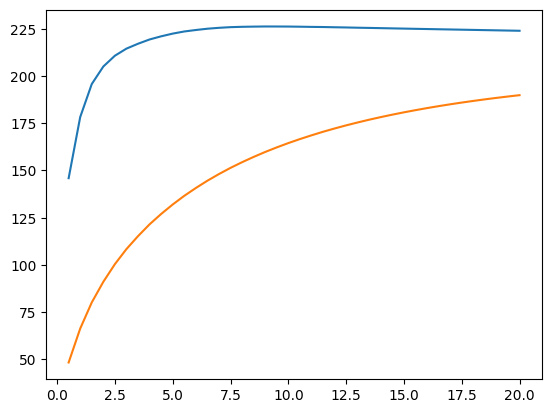

In [317]:
plt.plot(rs,np.sqrt(G*menc1/rs))
plt.plot(rs,np.sqrt(G*menc2/rs))

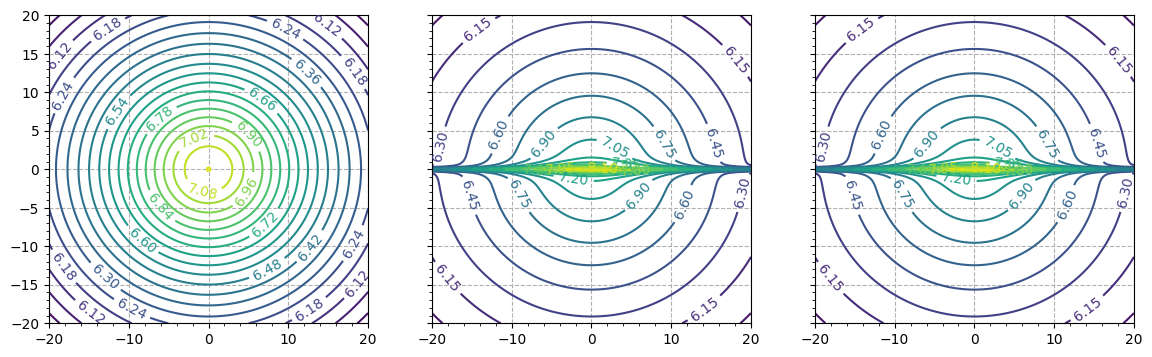

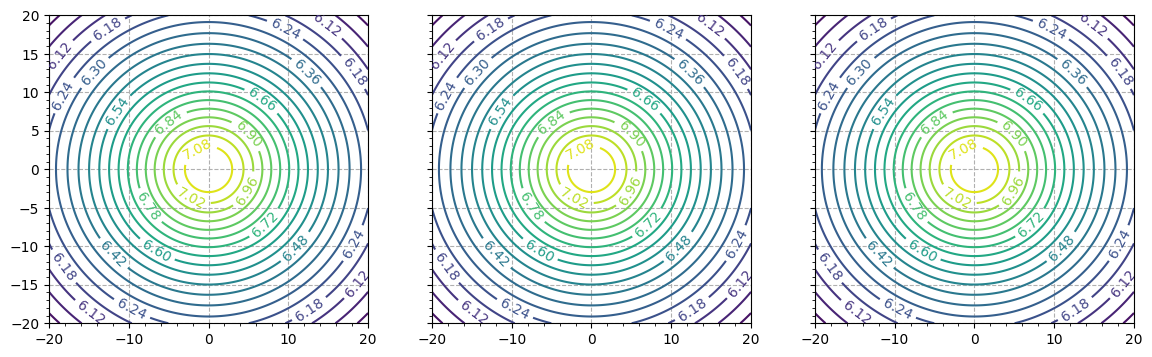

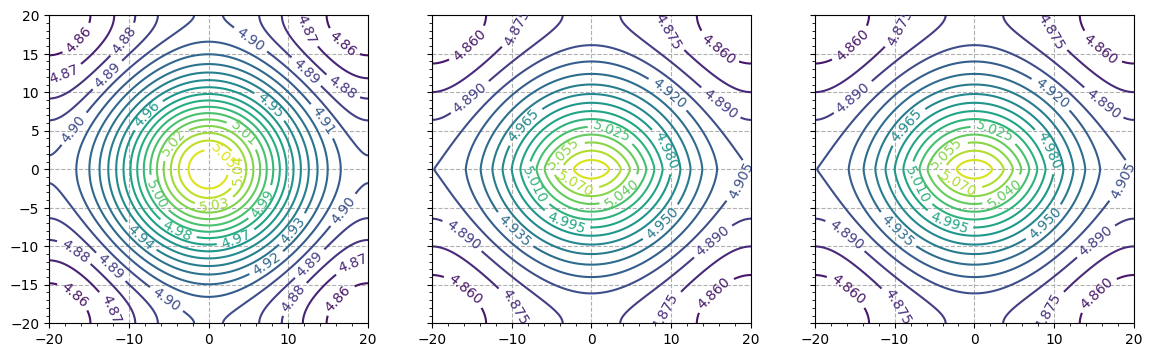

In [318]:
mid = props['mid']
xs = props['xs']

xx,yy = np.meshgrid(xs,xs)

fig, ax = plt.subplots(figsize=(14,4),nrows=1,ncols=3,sharex=True,sharey=True)

CS = ax[0].contour(xx,yy, np.log(storage['rho_01_xy'].T)/np.log(10),levels=20)
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].grid(linestyle='--')
ax[0].minorticks_on()
CS = ax[1].contour(xx,yy, np.log(storage['rho_01_xz'].T)/np.log(10),levels=20)
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].grid(linestyle='--')
ax[1].minorticks_on()
CS = ax[2].contour(xx,yy, np.log(storage['rho_01_yz'].T)/np.log(10),levels=20)
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].grid(linestyle='--')
ax[2].minorticks_on()
#plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14,4),nrows=1,ncols=3,sharex=True,sharey=True)

CS = ax[0].contour(xx,yy, np.log(storage['rhodm_01_xy'].T)/np.log(10),levels=20)
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].grid(linestyle='--')
ax[0].minorticks_on()
CS = ax[1].contour(xx,yy, np.log(storage['rhodm_01_xz'].T)/np.log(10),levels=20)
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].grid(linestyle='--')
ax[1].minorticks_on()
CS = ax[2].contour(xx,yy, np.log(storage['rhodm_01_yz'].T)/np.log(10),levels=20)
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].grid(linestyle='--')
ax[2].minorticks_on()
#plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(14,4),nrows=1,ncols=3,sharex=True,sharey=True)


CS = ax[0].contour(xx,yy, np.log(-storage['pot_01_xy'].T)/np.log(10),levels=20)
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].grid(linestyle='--')
ax[0].minorticks_on()
CS = ax[1].contour(xx,yy, np.log(-storage['pot_01_xz'].T)/np.log(10),levels=20)
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].grid(linestyle='--')
ax[1].minorticks_on()
CS = ax[2].contour(xx,yy, np.log(-storage['pot_01_yz'].T)/np.log(10),levels=20)
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].grid(linestyle='--')
ax[2].minorticks_on()
#plt.tight_layout()
plt.show()



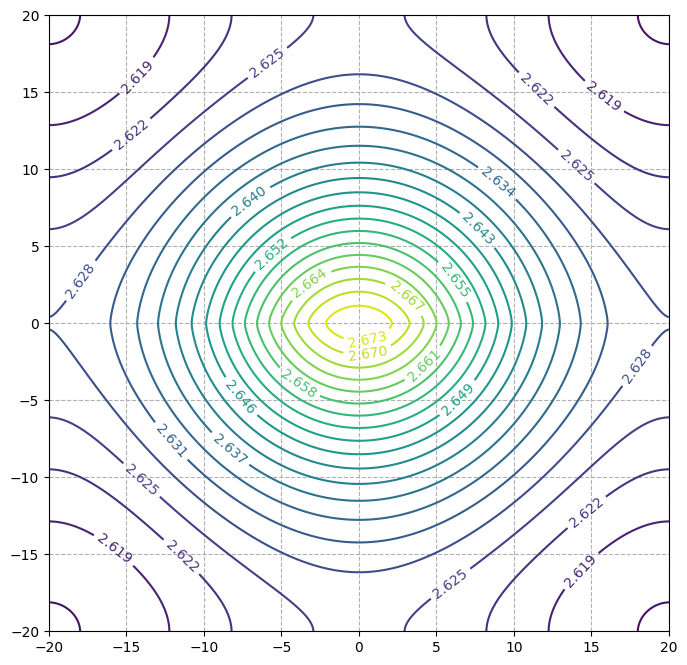

In [319]:
ageofgalaxy = 10
sigmaoverm  = 2.1e-11  ## 1 cm^2/g = 2.08e-10 kpc^2/msun 

plt.figure(figsize=(8,8))
CS = plt.contour(xx,yy,np.log(np.sqrt(1e5-storage['pot_01_yz'].T))/np.log(10),levels=20)
plt.clabel(CS, inline=True, fontsize=10)
plt.grid(linestyle='--')


In [271]:
np.power(10,2.3)

199.52623149688787